# A Jupyter notebook to read tracking files and (ultimately) create a data package representation of these 

This notebook shows how to generate **objects** and **events** csv files from CMSO sample files, and then prepares a datapackage representation of these.

requires python 3.3.0

In [1]:
# import needed libraries
import sys
import io
import os
import csv
import pandas as pd

This exercise is here shown for data contained in different folders.

Choose one of the following files to reproduce this code, or, alternatively, add the path of another file you'd like to use.


(Comment the files you will NOT use).

In [2]:
# f = 'VIB\\tracking examples\\Ugent\\trajectories.csv' # Sami's toolbox - VIB
# f = 'VIB\\tracking examples\\Essen\\exp_1\\trajectories.csv' # Sami's toolbox - VIB
# f = os.path.join("Essen", "tracks_ctr.csv") # Essen's commercial toolbox
f = os.path.join("Essen", "tracks_CXCL1.csv") # Essen's commercial toolbox

# f = 'Radboudumc\\ExampleFile1_NucleusFeatures.xls' # an xls file (Radboudumc)
# f = 'UGent\\0001_mode1_z000_f000_tracking.txt' # a single-cell tracking UGent (CELLMIA commercial s/w)

The first part of this notebook reads some tracking files, and splits these up in **objects** and **events** csv files.

In [3]:
# utility function needed to read Excel files
import xlrd
from xlrd import XLRDError

def xls_to_csv(xls_file):
    
    x =  xlrd.open_workbook(xls_file)
    x1 = x.sheet_by_index(0)
    name, extension = os.path.splitext(f)
    csvfile = open(name + '.csv', 'wb')
    writecsv = csv.writer(csvfile, quoting=csv.QUOTE_ALL)

    for rownum in xrange(sh.nrows):
        writecsv.writerow(x1.row_values(rownum))

    csvfile.close()

In [4]:
# takes file chosen and # of rows to visualize
def import_file(f, n):
    #if an excel file, try to read it as such
    if f.endswith('.xls'):
        try:
            xls_to_csv(f)
        except XLRDError:
            #copy the file and save it as csv
            import shutil
            name, extension = os.path.splitext(f)
            shutil.copyfile(f, name + '.csv')
            f = name + '.csv'
            print('Not an excel file.' + ' Copied and simply renamed to csv.')
    # open the file and show a quick preview        
    with open(f, 'r') as reader:
        for i in range(n):
            print(reader.readline()) # print header

In [5]:
import_file(f, 5)

Line,Track N,Time Sample N,X,Y

1,1,1,80,576

2,1,2,80,572

3,1,3,88,568

4,1,4,92,564



In [6]:
# group the tabular data by the joint_identifier
def group_by_joint_id(f, joint_id):
    df = pd.read_table(f, sep=None, engine='python')
    # try to group by the joint_id
    try:
        grouped = df.groupby(joint_id)
        print(grouped.size()[:5])
        return grouped 
    except KeyError: # throw an error if the wrong id is passed
        print('Seems like ' + joint_id + " is not the right joint_identifier for " + os.path.basename(f))
        return None

In [7]:
# the joint_id needs to be provided by the user
# this is one of the column headers in the tracking file, and will most likely be of the form:
# track_no, Track ID, object_ID, Track N, and such
joint_identifier = 'Track N'
G = group_by_joint_id(f, joint_identifier)
print('Type of G: {}'.format(type(G)))

Track N
1     96
2    112
3    451
4    451
5    138
dtype: int64
Type of G: <class 'pandas.core.groupby.DataFrameGroupBy'>


In [8]:
# create objects and events dataframes
def split_in_objs_evnts(grouped):
    # put everything back into a dataframe
    dfs = []
    for name, group in grouped:
        df = group.reset_index()
        dfs.append(df)
        
    objects_df = pd.concat(dfs)
 
    events_df = pd.DataFrame(grouped.size()).reset_index()
    events_df.columns = [joint_identifier, 'events_size']
  
    return {'objs':objects_df, 'evnts':events_df}

In [9]:
# the dictionary
D = split_in_objs_evnts(G)

# make directory for the csv and the dp representation
wd = os.path.dirname(os.path.realpath(f))
directory = wd + os.sep + 'dp'
if not os.path.exists(directory):
    os.makedirs(directory)

In [10]:
# write the dataframes to csv
for k, v in D.items():
    v.to_csv(directory + os.sep + k + '.csv', index = False)

From here on, the code takes care of the data package representation

In [11]:
# requires pip install datapackage
# requires pip install jsontableschema
import datapackage as dp
import jsontableschema
from jsontableschema import infer

In [12]:
import collections
from collections import defaultdict
author = 'author'
author_email = 'author@email.com'

# the top level information
top = (
    ('title', 'cell tracking file'),
    ('name', 'tracking-file'),
    ('author', author),
    ('author_email', author_email),
    ('joint_identifier', joint_identifier)
    )

top_dict = defaultdict(list)
for k, v in top:
    top_dict[k].append((v))

In [13]:
top_dict.items()

dict_items([('title', ['cell tracking file']), ('author_email', ['author@email.com']), ('name', ['tracking-file']), ('author', ['author']), ('joint_identifier', ['Track N'])])

In [14]:
myDP = dp.DataPackage()
# top level information
for k, v in top_dict.items():
    myDP.descriptor[k] = v

myDP.descriptor['resources'] = []

    
for k, v in D.items():
    name = k
    path = k + '.csv'
    with io.open(directory + os.sep + k + '.csv') as stream:
        headers = stream.readline().rstrip('\n').split(',')
        values = csv.reader(stream)
        schema = infer(headers, values)
                  
    myDP.descriptor['resources'].append(
                {
                    "name": name,
                    "path": path,
                    "schema": schema,
                }
            )
    
    
print (myDP.to_json())

{"resources": [{"schema": {"fields": [{"title": "", "type": "integer", "name": "index", "description": "", "format": "default"}, {"title": "", "type": "integer", "name": "Line", "description": "", "format": "default"}, {"title": "", "type": "integer", "name": "Track N", "description": "", "format": "default"}, {"title": "", "type": "integer", "name": "Time Sample N", "description": "", "format": "default"}, {"title": "", "type": "integer", "name": "X", "description": "", "format": "default"}, {"title": "", "type": "integer", "name": "Y", "description": "", "format": "default"}]}, "name": "objs", "path": "objs.csv"}, {"schema": {"fields": [{"title": "", "type": "integer", "name": "Track N", "description": "", "format": "default"}, {"title": "", "type": "integer", "name": "events_size", "description": "", "format": "default"}]}, "name": "evnts", "path": "evnts.csv"}], "author": ["author"], "title": ["cell tracking file"], "author_email": ["author@email.com"], "name": ["tracking-file"], "

In [15]:
# write the datapackage.json to file
with open(directory + os.sep + 'dp.json', 'w') as f:
    f.write(myDP.to_json())

In [16]:
# push the data package to a pandas storage
descr = directory + os.sep + 'dp.json'
stg = dp.push_datapackage(descriptor = descr, backend = 'pandas')
print(stg.buckets)

['objs___objs', 'evnts___evnts']


In [17]:
objects = stg[stg.buckets[0]]
events = stg[stg.buckets[1]]

In [18]:
# aggregation
trajectories = pd.merge(objects, events, how = 'outer', on = joint_identifier)
print(trajectories.head())

   index  Line  Track N  Time Sample N   X    Y  events_size
0      0     1        1              1  80  576           96
1      1     2        1              2  80  572           96
2      2     3        1              3  88  568           96
3      3     4        1              4  92  564           96
4      4     5        1              5  92  560           96


Some plotting

In [19]:
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

In [20]:
x = 'X' # this is not OK, should read header from dp
y = 'Y'

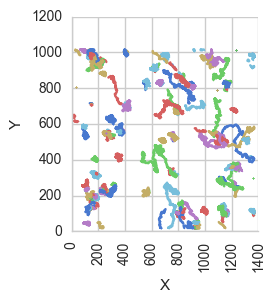

In [21]:
grid = sns.FacetGrid(trajectories, hue=joint_identifier, size = 3, palette='muted')
grid.map(plt.plot, x, y, marker="o", ms=1)
grid.set_xticklabels(rotation=90)

**Normalize to origin of system**

In [22]:
x_norm = x + 'norm'
y_norm = y + 'norm'

In [23]:
def normalize(dataset):
    list_ = []
    for track in dataset[joint_identifier].unique():
        temp_tracks = dataset[dataset[joint_identifier]==track]
        #the first x and y values
        x0, y0 = temp_tracks.iloc[0][x], temp_tracks.iloc[0][y]
        for index, row in temp_tracks.iterrows():
            current_x, current_y = row[x], row[y]
            xn, yn = current_x - x0, current_y - y0
            
            temp_tracks_row = temp_tracks.loc[[index]] # pass a list to .loc to be sure to get a dataframe: behavior is not consistent!
            temp_tracks_row[x_norm], temp_tracks_row[y_norm] = xn, yn
            list_.append(temp_tracks_row)
            
    dataset = pd.concat(list_)
    return dataset

In [24]:
norm = normalize(trajectories)
print(norm.head())

   index  Line  Track N  Time Sample N   X    Y  events_size  Xnorm  Ynorm
0      0     1        1              1  80  576           96      0      0
1      1     2        1              2  80  572           96      0     -4
2      2     3        1              3  88  568           96      8     -8
3      3     4        1              4  92  564           96     12    -12
4      4     5        1              5  92  560           96     12    -16


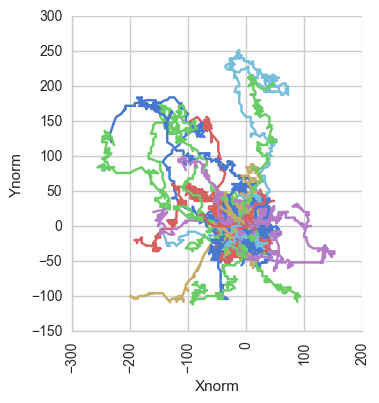

In [25]:
grid = sns.FacetGrid(norm, hue=joint_identifier, size=4, palette='muted')
grid.map(plt.plot, x_norm, y_norm, marker="o", ms=1)
grid.set_xticklabels(rotation=90)

**Compute turning angles**

In [26]:
import math
def compute_ta(dataset):
    list_ = []
    for track in dataset[joint_identifier].unique():
        temp_tracks = dataset[dataset[joint_identifier] == track]
        for i, row in temp_tracks.iterrows():
            temp_tracks_row = temp_tracks.loc[[i]]
            if i == 0:
                previousX, previousY = row[x], row[y]
                temp_tracks_row['ta']= float('NaN')
            else:
                delta_x, delta_y = row[x] - previousX, row[y] - previousY
                previousX, previousY = row[x], row[y]
                ta = math.atan2(delta_y, delta_x)
                temp_tracks_row['ta']= ta

            list_.append(temp_tracks_row)

    dataset = pd.concat(list_)
    return dataset

In [27]:
norm2 = compute_ta(norm)

In [28]:
theta = norm2.ta[~np.isnan(norm2.ta)]
theta_deg = theta.apply(math.degrees)
theta = pd.DataFrame(theta)
theta_deg = pd.DataFrame(theta_deg % 360) # (-180, + 180) mapped into (0, 360)

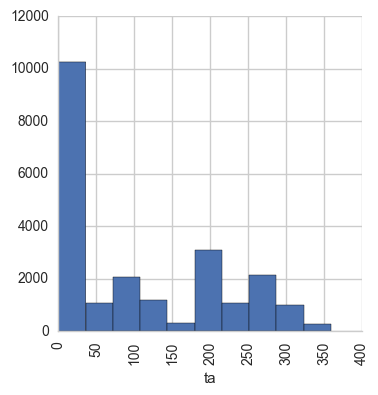

In [29]:
grid = sns.FacetGrid(theta_deg, size=4, palette='muted')
grid.map(plt.hist, 'ta', bins = 10)
grid.set_xticklabels(rotation=90)

In [32]:
def plot_polar(dataset, N):
    
    # dataset is the column of the frame to plot
    # N is the number of bin to use
    hist, bins = np.histogram(dataset, bins = N)
    
    # the width of the bins interval
    width = [t - s for s, t in zip(bins, bins[1:])]
    bins_ = bins[0:N] # exclude the last value 
    
    # the actual plotting logic
    g = sns.FacetGrid(theta, size = 4)
    radii = hist/max(hist)
    
    for ax in g.axes.flat:
        ax2 = plt.subplot(111, projection='polar')
        bars = ax2.bar(bins_, radii, width, bottom=0.0)
        for r,bar in zip(radii, bars):
            bar.set_facecolor(plt.cm.Spectral(r))
            bar.set_alpha(0.5)
    

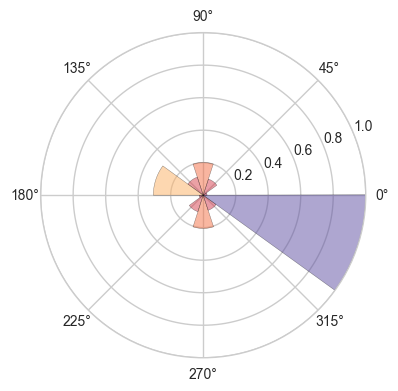

In [33]:
plot_polar(theta.ta, 10)